In [6]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from tqdm import tqdm

## Algo process detail
Description :
Given a "known" data distribution P with domain X, and a function f:X->f(x). Given n pts {x1, …, x_n } \in X not sampled from P, can you estimate E_P[f(x)] through these n pts? A: Use Riemann Stieltjes to get grids of X. And Use {f(x1), f(x2), …, f(xn)} to bestow value to all grids. (Like using nearest neighbor bestowing).

Implementing:
0. Given a function f
1. Given a distribution <br>
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
pdf(x, mean=None, cov=1, allow_singular=False)
cdf(x, mean=None, cov=1, allow_singular=False, maxpts=1000000*dim, abseps=1e-5, releps=1e-5, lower_limit=None)
rvs(mean=None, cov=1, size=1, random_state=None) # Draw random samples from a multivariate normal distribution.
2. sample n points from it
n = 20 <br>
x_s = rvs(mean=None, cov=1, size=n, random_state=None) <br>
f_x_s = [f(x) for x in x_s]
3. Generates m cubics grids # How?
Given Is = [I1, I2 ,..., Im] # m cubic
4. Compute center -> closest x_s -> bestow f(x_s) -> find p. of  each cube
5. Sum p. * f(x_s) to estimate E_p[f(x)]


In [7]:

def f_func(x):
    mean = [0.1, 0.37]

    # Define the covariance matrix (2x2)
    covariance = [[2.75, 0.53], [ 0.53, 2.75]]
    return multivariate_normal.pdf(x, mean=mean, cov=covariance, allow_singular=False)

# Define the mean vector (2-dimensional)
mean = [0, 0]

# Define the covariance matrix (2x2)
covariance = [[3, 0], [0, 1]]

# Number of samples to generate
n = 5

# Generate n samples from the 2-dimensional normal distribution
samples = multivariate_normal.rvs(mean=mean, cov=covariance, size=n)

def sample_generator(mean, covariance, size_n ):
    return multivariate_normal.rvs(mean=mean, cov=covariance, size= size_n)

print(samples)

[[ 0.05861303  0.24206201]
 [-0.95262748 -0.46796142]
 [ 0.27496071  1.40197714]
 [ 0.17149121  0.91571767]
 [ 1.31083357  1.6219507 ]]


In [8]:
n = 100000

# Generate n samples from the 2-dimensional normal distribution
golden_samples = multivariate_normal.rvs(mean=mean, cov=covariance, size=n)
f_samples = [f_func(sample) for sample in golden_samples]
answer = np.mean(f_samples)
print('answer', answer)


answer 0.03384387301144229


In [9]:

def get_cubes(points):

    unique_x = np.unique(points[:, 0])
    unique_y = np.unique(points[:, 1])

    # Sort coordinates
    unique_x = np.sort(unique_x)
    unique_y = np.sort(unique_y)

    # Extend coordinates to include negative and positive infinity regions
    # unique_x_extended = np.append(np.append(-np.inf, unique_x), np.inf)
    # unique_y_extended = np.append(np.append(-np.inf, unique_y), np.inf)
    unique_x_extended = unique_x
    unique_y_extended = unique_y

    # Generate all possible rectangles (cubes) with four vertices
    cubes = []
    for i in range(len(unique_x_extended) - 1):
        for j in range(len(unique_y_extended) - 1):
            x1, x2 = unique_x_extended[i], unique_x_extended[i + 1]
            y1, y2 = unique_y_extended[j], unique_y_extended[j + 1]
            cube = [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]
            cubes.append(cube)
    return cubes

def cube_centers(cubes):
    centers = []
    for cube in cubes:
        finite_vertices = [vertex for vertex in cube if not np.isinf(vertex).any()]
        if len(finite_vertices) == 0:
            continue  # Skip if all vertices are infinite
        x_coords = [vertex[0] for vertex in finite_vertices]
        y_coords = [vertex[1] for vertex in finite_vertices]
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)
        centers.append((center_x, center_y))

    return centers

class good_cdf(): 
    def __init__(self, mean, covariance) -> None:
        self.mean , self.covariance = mean, covariance
        
    def cdf(self, x, y):
        if -np.inf in (x, y):
            return 0
        else:
            return multivariate_normal.cdf([x, y], mean=mean, cov=covariance)

def cube_probability(cube, mean, covariance):
    """
    Compute the probability of a cube using the CDF of its finite vertices.

    Parameters:
        cube (list of tuples): List of four tuples representing the vertices of the cube.
        mean (list): Mean of the multivariate normal distribution.
        covariance (list of lists): Covariance matrix of the multivariate normal distribution.

    Returns:
        float: Probability of the cube.
    """
    normal_rv = good_cdf(mean, covariance)
    # Filter out vertices at positive or negative infinity
    finite_vertices = [vertex for vertex in cube ]

    if len(finite_vertices) < 2:
        return 0  # If less than 2 finite vertices, the cube doesn't have a finite area
    
    # Extract coordinates of the finite vertices
    x_coords = [vertex[0] for vertex in finite_vertices]
    y_coords = [vertex[1] for vertex in finite_vertices]

    # Compute the probability of the cube using multivariate normal CDF
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    

    prob_cube = normal_rv.cdf(x_max, y_max) - \
                normal_rv.cdf(x_min, y_max) - \
                normal_rv.cdf(x_max, y_min) + \
                normal_rv.cdf(x_min, y_min)
    # prob_cube = multivariate_normal.cdf([x_max, y_max], mean=mean, cov=covariance) - \
    #             multivariate_normal.cdf([x_min, y_max], mean=mean, cov=covariance) - \
    #             multivariate_normal.cdf([x_max, y_min], mean=mean, cov=covariance) + \
    #             multivariate_normal.cdf([x_min, y_min], mean=mean, cov=covariance)
    
    return prob_cube

def closest_points_indices(centers, points):
    """
    Find the indices of the closest points to each center from a given set of points.

    Parameters:
        centers (list of tuples): List of tuples representing the coordinates of the centers.
        points (list of tuples): List of tuples representing the coordinates of the points.

    Returns:
        list: A list where each element represents the index of the closest point to each center.
    """
    closest_points_indices_list = []

    # Iterate over each center
    for center in centers:
        min_distance = float('inf')
        closest_point_index = None

        # Iterate over each point to find the closest one to the center
        for point_index, point in enumerate(points):
            distance = np.linalg.norm(np.array(center) - np.array(point))
            if distance < min_distance:
                min_distance = distance
                closest_point_index = point_index

        closest_points_indices_list.append(closest_point_index)

    return closest_points_indices_list

def RSest(f_func, mean, covariance, samples):
    cubes = get_cubes(samples)
    centers = cube_centers(cubes)
    probs_over_cube = [cube_probability(cube, mean, covariance) for cube in cubes]
    cls_indices = closest_points_indices(centers, samples)
    f_samples = [f_func(sample) for sample in samples]
    cube_f = [f_samples[index] for index in cls_indices ]
    return np.sum( [ cube_f[i] * probs_over_cube[i] for i in range(len(cube_f))])

RSest(f_func, mean, covariance, samples)

0.01641827503799641

In [10]:
def MCest(f_func, samples):
    return np.mean([f_func(sample) for sample in samples])
MCest(f_func, samples)

0.04901539567821277

In [11]:
n_runs = 1000
size_n = 10
mean = [0, 0]
covariance = [[3, 0], [0, 1]]

sample_set = [ sample_generator(mean, covariance, size_n) for n in range(n_runs) ]
RSe_list = [RSest(f_func, mean, covariance, samples) for samples in tqdm(sample_set) ]
MC_list = [MCest(f_func, samples) for samples in tqdm(sample_set) ]



100%|██████████| 1000/1000 [00:00<00:00, 2762.11it/s]


In [12]:
# MC_list

In [13]:
# RSe_list

In [14]:
print('answer', answer)
print(f'mean rse: {np.mean(RSe_list)}, var rse: {np.var(RSe_list)}')
print(f'mean mc: {np.mean(MC_list)}, var rse: {np.var(MC_list)}')


answer 0.03384387301144229
mean rse: 0.02608357762382225, var rse: 2.189251022315325e-05
mean mc: 0.03348632688621715, var rse: 2.9016085444880773e-05


Centers of each valid cube:
(-0.72012401, -1.5078293)
(-0.72012401, -1.347052465)
(-0.72012401, -0.9826103099999999)
(-0.72012401, -0.42563593)
(-0.72012401, 0.48591161)
(-0.72012401, 1.04415009)
(-0.23053120000000002, -1.5078293)
(-0.2305312, -1.347052465)
(-0.2305312, -0.9826103099999999)
(-0.2305312, -0.42563593)
(-0.2305312, 0.48591161)
(-0.23053120000000002, 1.04415009)
(0.45610815000000005, -1.5078293)
(0.45610815000000005, -1.347052465)
(0.45610815000000005, -0.9826103099999999)
(0.45610815000000005, -0.42563593)
(0.45610815000000005, 0.48591161)
(0.45610815000000005, 1.04415009)
(0.928320985, -1.5078293)
(0.928320985, -1.347052465)
(0.928320985, -0.9826103099999999)
(0.928320985, -0.42563593)
(0.928320985, 0.48591161)
(0.928320985, 1.04415009)
(1.722962505, -1.5078293)
(1.722962505, -1.347052465)
(1.722962505, -0.9826103099999999)
(1.722962505, -0.42563593)
(1.722962505, 0.48591161)
(1.722962505, 1.04415009)
(2.24243773, -1.5078293)
(2.24243773, -1.347052465)
(2.24243773, -0.98

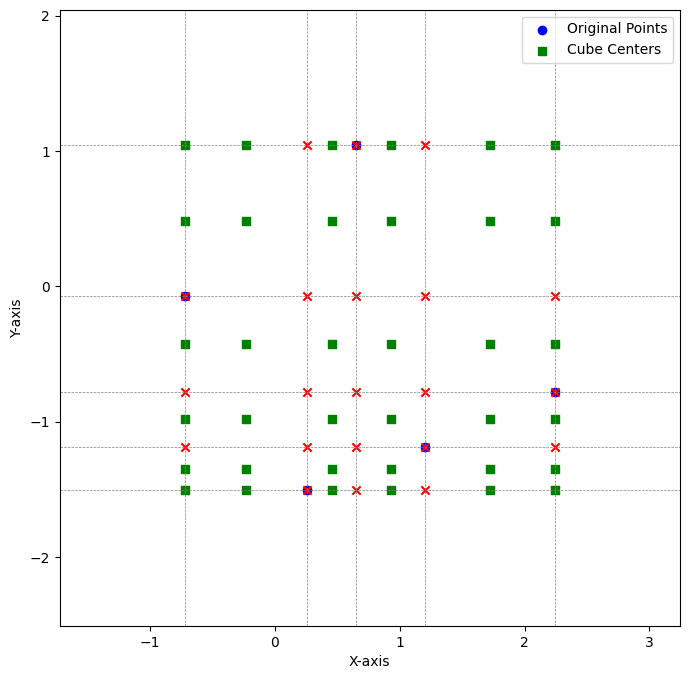

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Given 2D points
points = np.array([
    [ 1.20348728, -1.18627563],
    [ 0.25906161, -1.5078293 ],
    [-0.72012401, -0.07232687],
    [ 2.24243773, -0.77894499],
    [ 0.65315469,  1.04415009]
])

# Extract and sort unique x and y coordinates
unique_x = np.unique(points[:, 0])
unique_y = np.unique(points[:, 1])

# Sort coordinates
unique_x = np.sort(unique_x)
unique_y = np.sort(unique_y)

# Extend coordinates to include negative and positive infinity regions
unique_x_extended = np.append(np.append(-np.inf, unique_x), np.inf)
unique_y_extended = np.append(np.append(-np.inf, unique_y), np.inf)

# Generate all possible rectangles (cubes) with four vertices
cubes = []
for i in range(len(unique_x_extended) - 1):
    for j in range(len(unique_y_extended) - 1):
        x1, x2 = unique_x_extended[i], unique_x_extended[i + 1]
        y1, y2 = unique_y_extended[j], unique_y_extended[j + 1]
        cube = [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]
        cubes.append(cube)

# Compute the center of each cube, skipping infinite vertices
centers = []
for cube in cubes:
    finite_vertices = [vertex for vertex in cube if not np.isinf(vertex).any()]
    if len(finite_vertices) == 0:
        continue  # Skip if all vertices are infinite
    x_coords = [vertex[0] for vertex in finite_vertices]
    y_coords = [vertex[1] for vertex in finite_vertices]
    center_x = np.mean(x_coords)
    center_y = np.mean(y_coords)
    centers.append((center_x, center_y))

# Print the centers
print("Centers of each valid cube:")
for center in centers:
    print(center)

# Plotting the points, grid, and centers
plt.figure(figsize=(8, 8))

# Plot the original points
plt.scatter(points[:, 0], points[:, 1], c='blue', marker='o', label='Original Points')

# Plot the grid vertices
for x in unique_x:
    for y in unique_y:
        plt.scatter(x, y, c='red', marker='x')

# Draw vertical and horizontal lines passing through each unique point
for x in unique_x:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
for y in unique_y:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# Plot the centers of each valid cube
for center in centers:
    plt.scatter(center[0], center[1], c='green', marker='s', label='Cube Centers' if center == centers[0] else "")

# Set x and y axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Set the range for the axes to include some padding around the points
padding = 1
x_min, x_max = points[:, 0].min() - padding, points[:, 0].max() + padding
y_min, y_max = points[:, 1].min() - padding, points[:, 1].max() + padding

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add a legend
plt.legend()

# Show the plot
plt.show()
